# Essay Writer

## Defining the AgentState and the Prompts

In [1]:
# Loading the API key from .env
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

In [2]:
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model='gpt-4o-mini', temperature=0)

In [3]:
from typing import TypedDict, List, Annotated

# Creating a class for the agent state
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [4]:
# Defining the planning prompt 
PLAN_PROMPT = '''You are an expert writer tasked with writing a high level outline of an essay.
Write such an outline for the user provided topic.
Give an outline of the essay along with any relevant notes or instructions for the sections.'''

# defining the prompt that will be used by the agent that's doing research after the planning step
# given a plan, it will generate some queries and pass them to Tavily
RESEARCH_PLAN_PROMPT = '''You are a researcher charged with providing information that can be used when writing the following essay.
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.'''

# Defining the writer prompt
WRITER_PROMPT = '''You are an essay assistant tasked with writing excellent 5-paragraph essays.
Generate the best essay possible for the user's request and the initial outline.
If the user provides critique, respond with a revised version of your previous attempts.
Utilize all the information below as needed: 

------

{content}'''

# Defining the reflection prompt
REFLECTION_PROMPT = '''You are a teacher grading an essay submission.
Generate critique and recommendations for the user's submission.
Provide detailed recommendations, including requests for length, depth, style, etc.'''

# Defining the research critique prompt
RESEARCH_CRITIQUE_PROMPT = ''''You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below).
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.'''


In [5]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [6]:
# Importing and instantiating a tavily client
from tavily import TavilyClient
import os

tavily = TavilyClient(api_key=os.environ['TAVILY_API_KEY'])


## Implementing the Agents and the Nodes

In [7]:
# Creating the planning node
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}


In [8]:
# Creating the reseach_plan_node
# It generates research queries based on a given task and retrieves relevant content using those queries
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}


In [9]:
# Creating the generation node
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    
    response = model.invoke(messages)
     
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [10]:
# Creating the reflection node
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}



In [11]:
# Creating the research critique node
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {'content': content}


## Defining the Conditional Edge

In [12]:
# Defining the conditional edge
def should_continue(state):
    if state['revision_number'] > state['max_revisions']:
        return END
    return 'reflect'


## Defining the Graph

In [13]:
builder = StateGraph(AgentState)

# Adding nodes to the graph
builder.add_node('planner', plan_node)
builder.add_node('generate', generation_node)
builder.add_node('reflect', reflection_node)
builder.add_node('research_plan', research_plan_node)
builder.add_node('research_critique', research_critique_node)

# Setting the entry point of the state graph
builder.set_entry_point('planner')

# Adding the conditional edge
builder.add_conditional_edges(
    'generate', 
    should_continue, 
    {END: END, 'reflect': 'reflect'}
)

# Adding regular edges
builder.add_edge('planner', 'research_plan')
builder.add_edge('research_plan', 'generate')

builder.add_edge('reflect', 'research_critique')
builder.add_edge('research_critique', 'generate')


In [14]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver.from_conn_string(':memory:')

graph = builder.compile(checkpointer=memory)

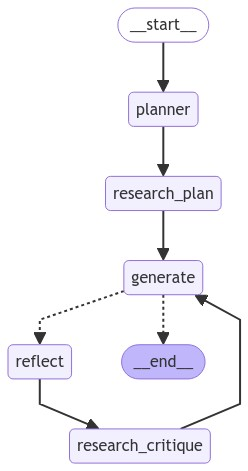

In [15]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


## Running the Agentic App

In [16]:
thread = {'configurable': {'thread_id': '1'}}
task = 'Nvidia  Blackwell AI chip'

prompt = {
    'task': task,
    'max_revisions': 2,
    'revision_number': 1,
}

events = graph.stream(prompt, thread)
for e in events:
    print(e)
    print('-' * 100)

{'planner': {'plan': "**Outline for Essay on Nvidia Blackwell AI Chip**\n\n**I. Introduction**\n   A. Background on Nvidia as a leader in AI and GPU technology\n      1. Brief history of Nvidia's innovations in AI and graphics processing\n      2. Importance of AI chips in modern computing\n   B. Introduction to the Blackwell AI chip\n      1. Overview of the Blackwell architecture\n      2. Significance of the Blackwell chip in the context of AI advancements\n\n**II. Technical Specifications of the Blackwell AI Chip**\n   A. Architecture and design features\n      1. Description of the chip's architecture (e.g., cores, memory, etc.)\n      2. Innovations in manufacturing processes (e.g., node size, materials)\n   B. Performance metrics\n      1. Benchmark comparisons with previous Nvidia chips (e.g., Ampere, Hopper)\n      2. Power efficiency and thermal management\n\n**III. Applications of the Blackwell AI Chip**\n   A. Use cases in various industries\n      1. Healthcare (e.g., medi

In [17]:
print(e['generate']['draft'])

**Nvidia Blackwell AI Chip: Pioneering the Future of Artificial Intelligence**

**I. Introduction**

Nvidia has long been recognized as a leader in the realms of artificial intelligence (AI) and graphics processing units (GPUs). Since its inception in 1993, the company has consistently pushed the boundaries of technology, from its early days of revolutionizing 3D graphics to its current dominance in AI computing. The importance of AI chips in modern computing cannot be overstated, as they serve as the backbone for a myriad of applications, ranging from data analysis to autonomous systems. Among its latest innovations, the Blackwell AI chip stands out as a significant advancement in the field, promising to enhance AI capabilities and drive further innovation.

The Blackwell architecture, named in honor of the esteemed statistician David Harold Blackwell, represents a leap forward in GPU technology. With its impressive specifications and groundbreaking features, the Blackwell chip is poi